In [0]:
import torch
from torchvision import datasets,transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
#transforms
transform=transforms.Compose([
                              transforms.Resize((224,224)),
                              transforms.RandomHorizontalFlip(),
                              transforms.RandomRotation(10),
                              transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
trainset=datasets.CIFAR10(root='/content/drive/My Drive',train=True,transform=transform,download=True)
testset=datasets.CIFAR10(root='/content/drive/My Drive',train=False,transform=transform,download=True)

valid_set=0.15
indices=list(range(len(trainset)))
np.random.shuffle
split=int(np.floor(valid_set*len(trainset)))
train_idx,valid_idx=indices[split:],indices[:split]
#SubsetSampler
train_sampler=SubsetRandomSampler(train_idx)
valid_sampler=SubsetRandomSampler(valid_idx)

#Data loader
train=torch.utils.data.DataLoader(trainset,batch_size=256,sampler=train_sampler)
valid_test=torch.utils.data.DataLoader(trainset,batch_size=128,sampler=valid_sampler)
test=torch.utils.data.DataLoader(testset,batch_size=64)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(img.permute(1,2,0))  # convert from Tensor image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

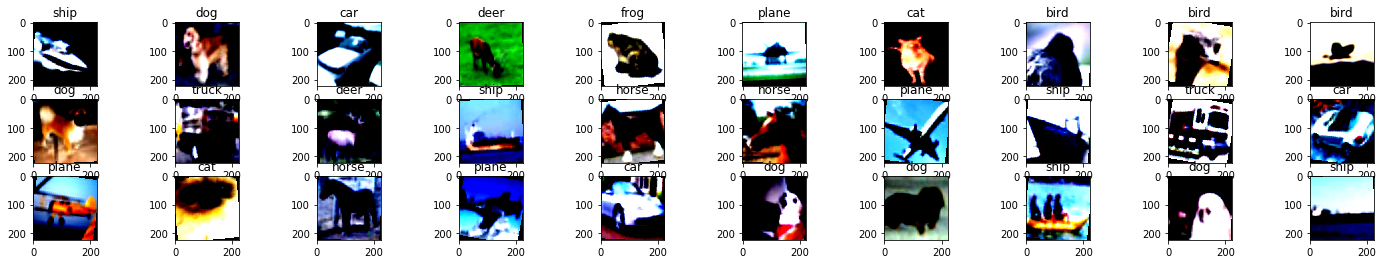

In [0]:
#visualize data
images,labels=next(iter(train))
fig=plt.figure(figsize=(25,4))
classes = ('plane', 'car', 'bird', 'cat',
        'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
labels=[classes[i] for i in labels]
for indx in range(30):
    ax=fig.add_subplot(3,30/3,indx+1)
    plt.imshow(images[indx].permute(1,2,0))
    ax.set_title(labels[indx])

**CNN**

In [0]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,16,3,padding=1)
        self.conv2=nn.Conv2d(16,32,3,padding=1)
        self.conv3=nn.Conv2d(32,64,3,padding=1)
        self.pool=nn.MaxPool2d(2,2)
        self.fc1=nn.Linear(64*4*4,512)
        self.fc2=nn.Linear(512,256)
        self.fc3=nn.Linear(256,10)
        self.dropout=nn.Dropout(0.25)
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=self.pool(F.relu(self.conv3(x)))
        x=x.view(-1,64*4*4)#to flatten last conv layer to full connected layer
        x=F.relu(self.fc1(x))
        x=self.dropout(x)
        x=F.relu(self.fc2(x))
        x=self.dropout(x)
        x=self.fc3(x)
        x=F.log_softmax(x,dim=1) #return scores
        return x

In [0]:
net=Network()
device=torch.device('cuda')
criterion=nn.NLLLoss()
optimizer=optim.Adam(net.parameters())
net.to(device)
t_loss,v_loss=[],[]
min_loss=np.Inf
for i in range(40):
    train_loss=0
    valid_loss=0
    net.train()
    for images,labels in train:
        images,labels=images.to(device),labels.to(device)
        #avoid accumulate 
        optimizer.zero_grad()
        #feedforward
        log_scores=net.forward(images)
        #loss
        loss=criterion(log_scores,labels)
        #bacward
        loss.backward()
        #optimize
        optimizer.step()
        train_loss+=loss.item()
    else:
        correct=0
        total=0
        net.eval()
        with torch.no_grad():
            for images,labels in valid_test:
                images,labels=images.to(device),labels.to(device)
                #scores
                log_scores=net.forward(images)
                ps=torch.exp(log_scores)
                #loss
                valid_loss+=criterion(log_scores,labels).item()
                #accuracy
                top_s,top_c=ps.topk(1,dim=1)
                correct+=(top_c==labels.view(*top_c.shape)).sum().item()
                total+=labels.shape[0]
            accuracy=correct/total
            v_loss.append(valid_loss/len(valid_test))
            t_loss.append(train_loss/len(train))
            val_Loss=valid_loss/len(valid_test)
        print(f'Epocs====>>>>{i}')
        print(f'\tTrain loss{train_loss/len(train)}')
        print(f'\tvalidation loss{val_Loss}')
        print(f'\tAccuracy{accuracy}')
        if val_Loss<min_loss:
            print("saving model")
            torch.save(net.state_dict(),'cifar.pth')
            min_loss=val_Loss

Epocs====>>>>0
	Train loss1.696733123915536
	validation loss1.3986985481391518
	Accuracy0.4868
saving model
Epocs====>>>>1
	Train loss1.357469745865442
	validation loss1.216414540500964
	Accuracy0.5718666666666666
saving model
Epocs====>>>>2
	Train loss1.2047293347523624
	validation loss1.0928949440939952
	Accuracy0.6146666666666667
saving model
Epocs====>>>>3
	Train loss1.0973692374121873
	validation loss1.0202555035130452
	Accuracy0.6424
saving model
Epocs====>>>>4
	Train loss1.0171167825397691
	validation loss1.0452465879715096
	Accuracy0.6328
Epocs====>>>>5
	Train loss0.961917715951016
	validation loss0.9157225343130403
	Accuracy0.6804
saving model
Epocs====>>>>6
	Train loss0.9045099524627055
	validation loss0.8941728753053536
	Accuracy0.6778666666666666
saving model
Epocs====>>>>7
	Train loss0.8684424081691225
	validation loss0.8745921420848976
	Accuracy0.6952
saving model
Epocs====>>>>8
	Train loss0.8410219238216715
	validation loss0.8658497788138309
	Accuracy0.6952
saving model


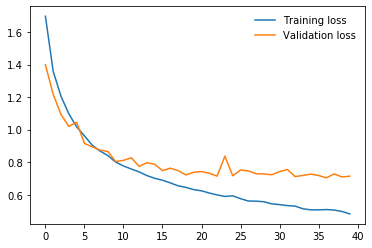

In [0]:
plt.plot(t_loss, label='Training loss')
plt.plot(v_loss, label='Validation loss')
plt.legend(frameon=False)

In [0]:
#No of Parameters
parameters=sum(p.numel() for p in net.parameters())
parameters

682282

In [0]:
#Test time
model=Network()
model.load_state_dict(torch.load('cifar.pth'))
model.to(device)
correct=0
total=0
with torch.no_grad():
    model.eval()
    for images,labels in test:
        images,labels=images.to(device),labels.to(device)
        output=model.forward(images)
        scores=torch.exp(output)
        top_s,top_c=scores.topk(1,dim=1)
        correct+=(top_c==labels.view(*top_c.shape)).sum().item()
        total+=labels.shape[0]
print(f"Accuracy is {correct/total}")

Accuracy is 0.7535


In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [0]:
correct_class=[0. for i in range(10)]
total_class=[0. for i in range(10)]
test_batch=16
with torch.no_grad():
    model.eval()
    for images,labels in test:
        images,labels=images.to(device),labels.to(device)
        output=model.forward(images)
        scores=torch.exp(output)
        top_s,top_c=scores.topk(1,dim=1)
        correct=(top_c==labels.view(*top_c.shape))
        for i in range(test_batch):
            total_class[labels[i]]+=1
            correct_class[labels[i]]+=correct[i].item()

In [0]:
for i in range(10):
    print(f"Accuracy of {classes[i]} is {100*(correct_class[i]/total_class[i])}")

Accuracy of plane is 87.17948717948718
Accuracy of car is 91.46341463414635
Accuracy of bird is 63.345195729537366
Accuracy of cat is 54.54545454545454
Accuracy of deer is 60.792951541850215
Accuracy of dog is 64.8
Accuracy of frog is 75.40322580645162
Accuracy of horse is 83.6
Accuracy of ship is 84.49612403100775
Accuracy of truck is 78.8679245283019


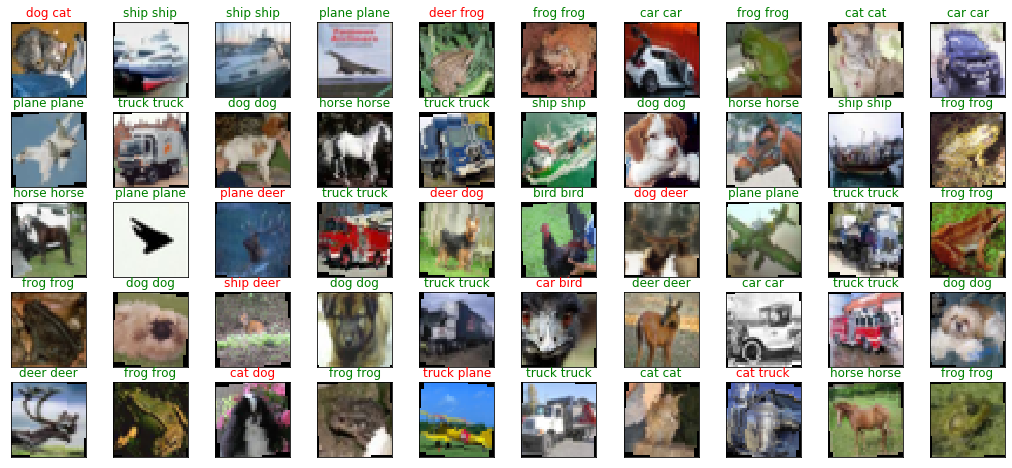

In [0]:
#visualize data
images,labels=next(iter(test))
classes = ('plane', 'car', 'bird', 'cat',
        'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

with torch.no_grad():
    images,labels=next(iter(test))
    model.eval()
    images,labels=images.to(device),labels.to(device)
    output=model.forward(images)
    scores=torch.exp(output)
    top_s,top_c=scores.topk(1,dim=1)
top_c=top_c.to('cpu')
fig=plt.figure(figsize=(18,8))
pred=[classes[i] for i in top_c]
for indx in range(50):
    ax=fig.add_subplot(5,50/5,indx+1,xticks=[], yticks=[])
    plt.imshow(((images[indx]).to('cpu')).permute(1,2,0))
    ax.set_title(f'{pred[indx]} {(classes[labels[indx]])}',color='green' if pred[indx]==classes[labels[indx]] else'red')


**Pretrained Model-vgg**

In [0]:
from torchvision import models
models=models.vgg16(pretrained=True)
device=torch.device('cuda')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
#Perform Transfer Learning (replacing last layer and classifier)
#freeze all weights no backprop performed
from collections import OrderedDict
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
#freeze all weights of vgg 16
for param in models.features.parameters():
    param.requires_grad=False
classifier=nn.Sequential(OrderedDict([
                        ('fc1',nn.Linear(25088,4096)),
                        ('relu1',nn.ReLU()),
                        ('dropout1',nn.Dropout(0.25)),
                        ('fc2',nn.Linear(4096,4096)),
                        ('relu2',nn.ReLU()),
                        ('dropout2',nn.Dropout(0.2)),
                        ('fc3',nn.Linear(4096,256)),
                        ('relu1',nn.ReLU()),
                        ('dropout3',nn.Dropout(0.2)),
                        ('fc4',nn.Linear(256,10)),
                        ('output',nn.LogSoftmax(dim=1))
                        ]))
#now replace last fc layers by transfer learning
models.classifier=classifier

In [0]:
models

In [0]:
criterion=nn.NLLLoss()
optimizer=optim.Adam(models.classifier.parameters())
t_loss,v_loss=[],[]
models.to(device)
min_loss=np.Inf
for i in range(50):
    train_loss=0
    valid_loss=0
    models.train()
    for images,labels in train:
        images,labels=images.to(device),labels.to(device)
        #avoid accumulate 
        optimizer.zero_grad()
        #feedforward
        log_scores=models.forward(images)
        #loss
        loss=criterion(log_scores,labels)
        #bacward
        loss.backward()
        #optimize
        optimizer.step()
        train_loss+=loss.item()
    else:
        correct=0
        total=0
        models.eval()
        with torch.no_grad():
            for images,labels in valid_test:
                images,labels=images.to(device),labels.to(device)
                #scores
                log_scores=models(images)
                ps=torch.exp(log_scores)
                #loss
                valid_loss+=criterion(log_scores,labels).item()
                #accuracy
                top_s,top_c=ps.topk(1,dim=1)
                correct+=(top_c==labels.view(*top_c.shape)).sum().item()
                total+=labels.shape[0]
            accuracy=correct/total
            v_loss.append(valid_loss/len(valid_test))
            t_loss.append(train_loss/len(train))
            val_Loss=valid_loss/len(valid_test)
        print(f'Epocs====>>>>{i}')
        print(f'\tTrain loss{train_loss/len(train)}')
        print(f'\tvalidation loss{val_Loss}')
        print(f'\tAccuracy{accuracy}')
        if val_Loss<min_loss:
            print("saving model")
            torch.save(models.state_dict(),'cifar2.pth')
            min_loss=val_Loss        

Epocs====>>>>0
	Train loss0.3299358325625608
	validation loss0.4442207479881028
	Accuracy0.8562666666666666
saving model
Epocs====>>>>1
	Train loss0.3166000286262192
	validation loss0.44079348798525536
	Accuracy0.8558666666666667
saving model
Epocs====>>>>2
	Train loss0.3003872910481013
	validation loss0.43362474643577964
	Accuracy0.8585333333333334
saving model
Epocs====>>>>3
	Train loss0.29700605544501435
	validation loss0.45649929824521984
	Accuracy0.8508
Epocs====>>>>4
	Train loss0.28764705672235547
	validation loss0.4530488878993665
	Accuracy0.8525333333333334
Epocs====>>>>5
	Train loss0.2957280414725492
	validation loss0.46991640935509893
	Accuracy0.8474666666666667
Epocs====>>>>6
	Train loss0.28459018584853873
	validation loss0.42921262979507446
	Accuracy0.8597333333333333
saving model
Epocs====>>>>7
	Train loss0.27122809028554107
	validation loss0.4345748171967975
	Accuracy0.8585333333333334
Epocs====>>>>8
	Train loss0.25426268854184064
	validation loss0.45819666754391236
	Accu

In [0]:
#Test time
models.load_state_dict(torch.load('cifar2.pth'))
models.to(device)
correct=0
total=0
with torch.no_grad():
    models.eval()
    for images,labels in test:
        images,labels=images.to(device),labels.to(device)
        output=models.forward(images)
        scores=torch.exp(output)
        top_s,top_c=scores.topk(1,dim=1)
        correct+=(top_c==labels.view(*top_c.shape)).sum().item()
        total+=labels.shape[0]
print(f"Accuracy is {correct/total}")

Accuracy is 0.8492


In [0]:
correct_class=[0. for i in range(10)]
total_class=[0. for i in range(10)]
test_batch=16
with torch.no_grad():
    models.eval()
    for images,labels in test:
        images,labels=images.to(device),labels.to(device)
        output=models.forward(images)
        scores=torch.exp(output)
        top_s,top_c=scores.topk(1,dim=1)
        correct=(top_c==labels.view(*top_c.shape))
        for i in range(test_batch):
            total_class[labels[i]]+=1
            correct_class[labels[i]]+=correct[i].item()

In [0]:
for i in range(10):
    print(f"Accuracy of {classes[i]} is {100*(correct_class[i]/total_class[i])}")

Accuracy of plane is 79.91452991452992
Accuracy of car is 95.52845528455285
Accuracy of bird is 82.20640569395017
Accuracy of cat is 71.93675889328063
Accuracy of deer is 80.1762114537445
Accuracy of dog is 74.4
Accuracy of frog is 84.2741935483871
Accuracy of horse is 90.4
Accuracy of ship is 89.14728682170544
Accuracy of truck is 86.79245283018868


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

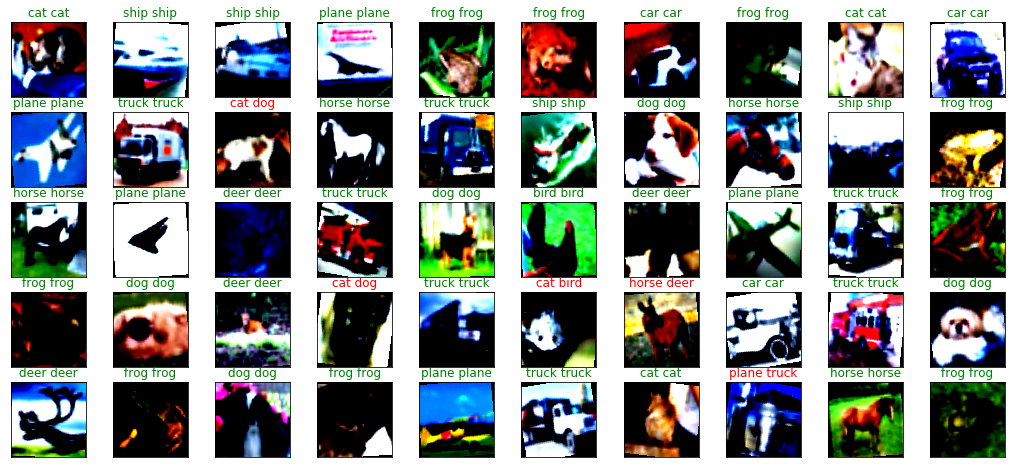

In [0]:
#visualize data
images,labels=next(iter(test))
classes = ('plane', 'car', 'bird', 'cat',
        'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

with torch.no_grad():
    images,labels=next(iter(test))
    models.eval()
    images,labels=images.to(device),labels.to(device)
    output=models.forward(images)
    scores=torch.exp(output)
    top_s,top_c=scores.topk(1,dim=1)
top_c=top_c.to('cpu')
fig=plt.figure(figsize=(18,8))
pred=[classes[i] for i in top_c]
for indx in range(50):
    ax=fig.add_subplot(5,50/5,indx+1,xticks=[], yticks=[])
    plt.imshow(((images[indx]).to('cpu')).permute(1,2,0))
    ax.set_title(f'{pred[indx]} {(classes[labels[indx]])}',color='green' if pred[indx]==classes[labels[indx]] else'red')